# Import des packages nécessaires

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Récupération des fonctions des autres notebooks et des dataset

In [ ]:
#Entree par l'utilisateur de info sur son domicile 
dep = (input("Departement"))
num = int(input("Numero"))
nom_voie = input("Nom de la voie")
ville = input('Ville')
code_postal = input("Code postal")

In [2]:
dep, num, nom_voie, ville, code_postal = "44", 4, "Rue Fouré", "Nantes", "44000"

In [3]:
def addresse_to_GPS(dep, num, nom_voie, ville, code_postal):
    adresses_dep = pd.read_csv("https://adresse.data.gouv.fr/data/ban/adresses/latest/csv/adresses-"+dep+".csv.gz", compression='gzip', sep=";", error_bad_lines=False) #recuperation des adresses postales correspondant au département de l'utilisateur
    
    foyer_infos = adresses_dep[(adresses_dep["numero"] == num) & (adresses_dep["nom_commune"] == ville) & (adresses_dep["nom_voie"] == nom_voie)] 
    foyer = foyer_infos.to_numpy()
    foyer = foyer.tolist()

    
    longitude = foyer[0][12]
    latitude = foyer[0][13]

    return(longitude, latitude)

In [4]:
long, lat = addresse_to_GPS(dep, num, nom_voie, ville, code_postal)
long, lat

(-1.546307, 47.214242)

# Nucléaire 

### Récupération des tables de données

In [5]:
centrales = pd.read_csv("DataSets/centrales_nucleaires.csv",sep=',',encoding_errors='ignore')

In [6]:
import Nucleaire

In [8]:
rNu = Nucleaire.nucleaire(long, lat, centrales)
rNu

La centrale nucleaire la plus proche se situe à :
9979.717702772043 Fessenheim
Le risque nucléaire à cette adresse est de :


1

# Inondations

### Récupération des tables de données

In [ ]:
df_risque_inond=gpd.read_file("DataSets/tri_2020_sig_di/n_carte_inond_s.shp") 

# Glissement de terrains

### Récupération des tables de données

In [9]:
df_mvtTerrains13 = pd.read_csv("DataSets/mouvement_terrain_13.csv", sep = ";")
df_mvtTerrains31 = pd.read_csv("DataSets/mouvement_terrain_31.csv", sep = ";")
df_mvtTerrains44 = pd.read_csv("DataSets/mouvement_terrain_44.csv", sep = ";")

### Import des fonctions

In [10]:
import glissement_terrain

In [11]:
dico = glissement_terrain.event_less_10km(lat, long, df_mvtTerrains44)
rGliter = glissement_terrain.calcul_risque(dico, df_mvtTerrains44)
print(rGliter)

TypeError: 'float' object is not subscriptable

# Secheresse

### Récupération des tables de données

In [ ]:
df_secheresse=gpd.read_file("DataSets/AleaRG31_L93/AleaRG31_L93.shp") 

# Pollution

### Récupération des tables de données

In [ ]:
df_PM10 = pd.read_csv("DataSets/"+dep+"/PM10.csv", sep = ";")
df_SO2 = pd.read_csv("DataSets/"+dep+"/SO2.csv", sep = ";")
df_CO = pd.read_csv("DataSets/"+dep+"/CO.csv", sep = ";")

### code

In [ ]:
import Pollution

In [ ]:
rPol = Pollution.risque_polution(lat, long, df_CO, df_SO2, df_PM10)
rPol

# Temperature

### Récupération des tables de données

In [ ]:
df_temp13 = pd.read_csv("DataSets/temperature_13.csv", sep = ";")
df_temp31 = pd.read_csv("DataSets/temperature_31.csv", sep = ";")
df_temp44 = pd.read_csv("DataSets/temperature_44.csv", sep = ";")

### Code

In [ ]:
import temperature

# Code principal

In [12]:
def final_score(dep, num, nom_voie, ville, code_postal):
    rNu = Nucléaire.nucleaire(dep, num, nom_voie, ville, code_postal)
    rIn = Inondation.adresse_to_risque(dep,num,nom_voie,ville,code_postal)
    rGliTer = 
    return(nu)

SyntaxError: invalid syntax (3175398018.py, line 4)

In [13]:
final_score(dep, num, nom_voie, ville, code_postal)

NameError: name 'final_score' is not defined

In [15]:
sample_vect = [12/20, 13/20, 0.4, 6/20, 8/20, 10/20]


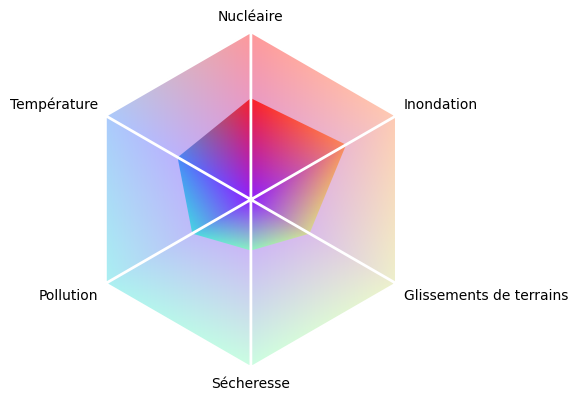

In [16]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri

proportions = sample_vect
labels = ['Nucléaire', 'Inondation', 'Glissements de terrains', 'Sécheresse', 'Pollution', 'Température']
N = len(proportions)
proportions = np.append(proportions, 1)
theta = np.linspace(0, 2 * np.pi, N, endpoint=False)
x = np.append(np.sin(theta), 0)
y = np.append(np.cos(theta), 0)
triangles = [[N, i, (i + 1) % N] for i in range(N)]
triang_backgr = tri.Triangulation(x, y, triangles)
triang_foregr = tri.Triangulation(x * proportions, y * proportions, triangles)
cmap = plt.cm.rainbow_r  # or plt.cm.hsv ?
colors = np.linspace(0, 1, N + 1)
plt.tripcolor(triang_backgr, colors, cmap=cmap, shading='gouraud', alpha=0.4)
plt.tripcolor(triang_foregr, colors, cmap=cmap, shading='gouraud', alpha=0.8)
plt.triplot(triang_backgr, color='white', lw=2)
for label, color, xi, yi in zip(labels, colors, x, y):
    plt.text(xi * 1.05, yi * 1.05, label,  # color=cmap(color),
             ha='left' if xi > 0.1 else 'right' if xi < -0.1 else 'center',
             va='bottom' if yi > 0.1 else 'top' if yi < -0.1 else 'center')
plt.axis('off')
plt.gca().set_aspect('equal')
plt.show()
